In [2]:
from tensorflow import keras

from tensorflow.keras import models, layers #type: ignore

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

from tqdm import tqdm
import matplotlib.pyplot as plt 
import numpy as np 

In [114]:
# Preparing the dataset and creating the features and target arrays

n_sims = 1000

x = []
y = []

for i in tqdm(range(n_sims), desc='Carregando dados', ascii=True):
    data = np.load(f'../input31/data_{i+1}.npy')
    x.append(data[:, :2])
    y.append(data[0, 2])  # equivalente a data[:, 2:][0][0]

x = np.array(x)
y = np.array(y)

norm = y.max()
# Normalização
# y /= y.max()


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25)

Carregando dados: 100%|##########| 1000/1000 [00:00<00:00, 5526.78it/s]


In [208]:
early_stopping = keras.callbacks.EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   
    patience=5,          
    verbose=1,          
    factor=0.5,          
    min_lr=0.00001       
)

learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,  # Initial learning rate for training
    decay_steps=1000,            # Number of steps before decaying the learning rate
    decay_rate=0.5,              # Rate at which the learning rate decreases
)

lr_callback = keras.callbacks.LearningRateScheduler(learning_rate_schedule)


In [218]:
# defining the model

model = models.Sequential()


model.add(layers.Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(31, 2)))
model.add(layers.MaxPooling1D(pool_size=2))

# model.add(layers.Conv1D(filters=32, kernel_size=4, activation='relu', input_shape=(31, 2)))
# model.add(layers.MaxPooling1D(pool_size=2))

# model.add(layers.GRU(16, input_shape=(80,2)))

model.add(layers.Flatten())


model.add(layers.Dense(16))
# model.add(layers.Dense(16))

model.add(layers.Dense(1))
model.compile(loss=keras.losses.MeanSquaredError(), optimizer='nadam')


history = model.fit(x_train, y_train, validation_split=.2, epochs=25, batch_size=8, verbose=1, callbacks=[reduce_lr])

Epoch 1/25
75/75 [==============================] - 1s 6ms/step - loss: 498.1306 - val_loss: 0.8406 - lr: 0.0010
Epoch 2/25
75/75 [==============================] - 0s 7ms/step - loss: 0.8974 - val_loss: 0.8530 - lr: 0.0010
Epoch 3/25
75/75 [==============================] - 0s 6ms/step - loss: 0.9041 - val_loss: 0.9244 - lr: 0.0010
Epoch 4/25
75/75 [==============================] - 0s 6ms/step - loss: 0.9103 - val_loss: 1.1311 - lr: 0.0010
Epoch 5/25
75/75 [==============================] - 0s 5ms/step - loss: 0.9082 - val_loss: 0.8558 - lr: 0.0010
Epoch 6/25
75/75 [==============================] - ETA: 0s - loss: 0.9479
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
75/75 [==============================] - 0s 5ms/step - loss: 0.9479 - val_loss: 0.9225 - lr: 0.0010
Epoch 7/25
75/75 [==============================] - 0s 5ms/step - loss: 0.9188 - val_loss: 0.8389 - lr: 5.0000e-04
Epoch 8/25
75/75 [==============================] - 0s 5ms/step - loss: 0.929

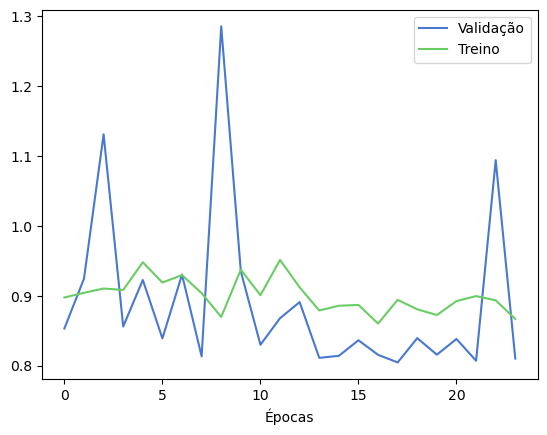

In [219]:
plt.plot(history.history['val_loss'][1:], label='Validação')
plt.plot(history.history['loss'][1:], label='Treino')


plt.xlabel('Épocas')
plt.legend()


# plt.savefig("imagens/loss_h0_cnn")

plt.show()

In [220]:
y_pred = model.predict(x_test)


r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

mse

8/8 [==============================] - 0s 2ms/step


0.7386993530434779

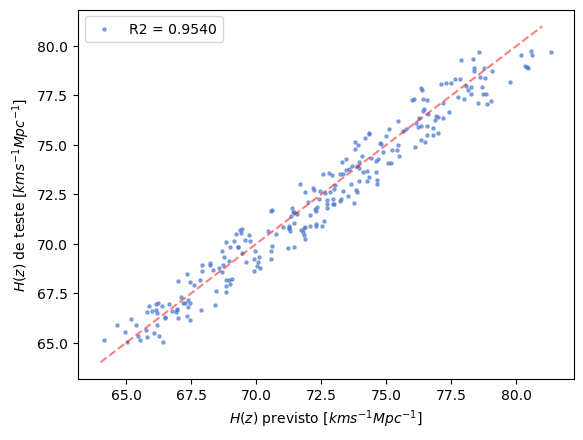

In [221]:
plt.style.use('seaborn-v0_8-muted')

linha = np.linspace(64, 81)
# linha = np.linspace(.31, .315, 2500)


# plt.scatter(y_pred*norm, y_test*norm, s=5, alpha=.6, label=f'R2 = {r2:.4f}')
plt.scatter(y_pred, y_test, s=5, alpha=.6, label=f'R2 = {r2:.4f}')
plt.plot(linha, linha, alpha=.5, c='red', ls='--')

plt.legend()


plt.xlabel(r'$H (z)$ previsto [$km s^{-1} Mpc^{-1}$] ')
plt.ylabel(r'$H (z)$ de teste [$km s^{-1} Mpc^{-1}$] ')

# plt.savefig("imagens/metrics_h0_cnn")
plt.show()

In [222]:
# forecasting "real" H(0)

real = np.load('../input31/data_real31.npy')
# real = real[real[:, 1].argsort()]

real = real.reshape(-1,31,2)

In [223]:

final_real = model.predict(real, verbose=0)

In [224]:
# final_real*norm
final_real

array([[73.12724]], dtype=float32)

In [225]:
# keras.utils.plot_model(model, to_file='imagens/model_cnn.png', show_shapes=False, show_layer_names=False)


In [226]:
# model.save('models/cnn')